<a href="https://colab.research.google.com/github/lisaong/stackup-workshops/blob/text_similarity_datasource/text-similarity/text_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
# load the medium-sized model
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


### After installing the above:

Runtime -> Restart Runtime

In [0]:
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pickle

plt.style.use('seaborn-whitegrid')

In [0]:
# loads the medium-sized english language model
# this includes: tokenizer, tagger, parser, named-entity recogniser, and word vectors
#  the default (en_core_web_sm) is fast but not as accurate.
#  the large (en_core_web_lg) can also be installed but it's a large download.
nlp = spacy.load("en_core_web_md")

## Word vectors

Like a dictionary for machines to consume.

Vectors are analogous to "definitions" that humans read.

In [183]:
# try it out with some text, we'll try a real text later.
tokens = nlp("man woman king queen")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov, token.vector)

man True 6.352939 False [-1.7310e-01  2.0663e-01  1.6543e-02 -3.1026e-01  1.9719e-02  2.7791e-01
  1.2283e-01 -2.6328e-01  1.2522e-01  3.1894e+00 -1.6291e-01 -8.8759e-02
  3.3067e-03 -2.9483e-03 -3.4398e-01  1.2779e-01 -9.4536e-02  4.3467e-01
  4.9742e-01  2.5068e-01 -2.0901e-01 -5.8931e-01  6.1615e-02  1.0434e-01
  2.4424e-01 -2.9120e-01  3.0746e-01  3.6276e-01  7.1151e-01 -8.0523e-02
 -5.9524e-01  3.4834e-01 -3.3048e-01  7.0316e-02  5.3329e-01 -2.9081e-01
  1.3459e-01 -3.9856e-01 -3.2435e-01  1.1867e-01 -1.4938e-01 -3.8256e-01
  3.3116e-01 -3.1488e-01 -9.4491e-02 -6.1319e-02  1.5518e-01 -2.5523e-01
 -1.1813e-01  2.5296e-01 -9.5174e-02 -1.6596e-01 -1.0840e-01  8.8803e-02
  2.0890e-01  4.3981e-01  1.0476e-03 -4.0666e-02  2.6487e-01 -6.1009e-01
 -1.4405e-01 -8.1185e-02  7.5475e-03  2.3373e-01 -2.7772e-02 -2.9315e-01
 -1.1744e-01 -8.3193e-02 -2.3768e-01  1.5735e-01 -5.6408e-01 -2.9323e-01
  1.6387e-02 -7.8160e-02 -2.1301e-01 -1.7845e-01 -3.0769e-01 -4.6203e-01
 -2.5220e-03  4.2973e-01 -4

In [184]:
# plot the word vectors in 2-D space

# doing a bit of list comprehension to get the vectors
# then dumping it into a numpy array
vectors = np.array([token.vector for token in tokens])

vectors.shape

(4, 300)

In [185]:
tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

# each of these are 2 dimensions
vectors_2d

array([[ -32.147305, -293.99146 ],
       [-114.43374 ,  -16.287865],
       [-309.85068 , -376.27866 ],
       [-392.13712 ,  -98.57503 ]], dtype=float32)

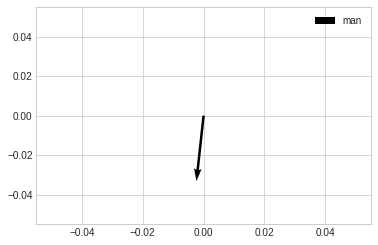

In [186]:
# here's one vector
plt.quiver([0], [0], vectors_2d[0, 0], vectors_2d[0, 1], 
           label=tokens[0].text,
           scale=1500) 
plt.legend()
plt.show()

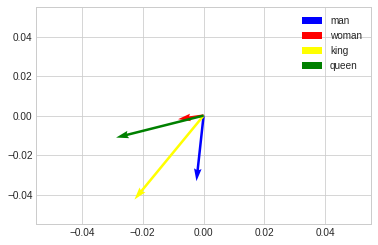

In [187]:
# let's plot all of them

colours = ['blue', 'red', 'yellow', 'green']

for i in range(len(tokens)):
  plt.quiver([0], [0], vectors_2d[i, 0], vectors_2d[i, 1], 
             label=tokens[i].text,
             scale=1500,
             color=colours[i])

plt.legend()
plt.show()

## Measuring similarity

We can measure the similarity (cosine similarity) of two word vectors.

Nearer to 1: more similar

Nearer to 0: less similar 

In [188]:
# Explore more word vectors

# create a dictionary
word_to_token = { token.text : token for token in tokens }
word_to_token

{'king': king, 'man': man, 'queen': queen, 'woman': woman}

In [189]:
word_to_token['queen'].similarity(word_to_token['woman'])

0.40660653

In [190]:
word_to_token['king'].similarity(word_to_token['man'])

0.4088461

In [191]:
word_to_token['king'].similarity(word_to_token['woman'])

0.26556593

In [192]:
word_to_token['man'].similarity(word_to_token['woman'])

0.7401745

### Dot product between two vectors also gives the measure of similarity

Larger value: more similar

Smaller value: less similar

In [193]:
np.dot(word_to_token['queen'].vector, word_to_token['woman'].vector)

19.15795

In [194]:
np.dot(word_to_token['man'].vector, word_to_token['woman'].vector)

32.439884

In [195]:
np.dot(word_to_token['king'].vector, word_to_token['woman'].vector)

13.084201

## Application: How much does a text match topics of interest

1. Take any text
2. Tokenise it into words
3. Get the list of word vectors
4. Do a dot product with each topic keyword
5. Rank the dot products to find out the highest matching keywords

Q: what are the advantages/disadvantages of this approach over simple string search / matching?

In [0]:
# let's find some text
# https://www.kdramapal.com/highest-rated-korean-dramas-cable-all-time/

TEXT = """Signal is so good because it properly exploits the mystery and thrill aspect so profoundly, giving the viewers an emotionally gripping experience that would leave them in awe at certain scenes. It centers on a modern-day criminal profiler (Lee Je-hoon, Where Stars Land) who solves cold cases with the help of a detective (Cho Jin-woong, Entourage) from the past with whom he communicates through a mysterious walkie-talkie. The series received critical acclaim for its superb plot, solid acting, and sophisticated direction. It won Best Drama, Best Screenplay, and Best Actress at the 2016 Baeksang Arts Awards. It pulled in a peak rating of 12.5 percent."""

In [197]:
text_tokens = nlp(TEXT)
len(text_tokens)

129

In [198]:
text_tokens[0].text

'Signal'

In [199]:
text_tokens[1].text

'is'

### Removing common words

Stop words (such as "is", "a", "the") don't contribute much to the meaning of the text.

We can find them by checking the is_stop flag for each token.

In [200]:
text_tokens[0].text, text_tokens[0].is_stop

('Signal', False)

In [201]:
text_tokens[1].text, text_tokens[1].is_stop

('is', True)

In [202]:
# filter out stop words
# list comprehension again!
text_tokens_clean = [token for token in text_tokens if not token.is_stop]

len(text_tokens_clean)

87

In [203]:
# what is the result?
' '.join([token.text for token in text_tokens_clean])

'Signal good properly exploits mystery thrill aspect profoundly , giving viewers emotionally gripping experience leave awe certain scenes . centers modern - day criminal profiler ( Lee Je - hoon , Stars Land ) solves cold cases help detective ( Cho Jin - woong , Entourage ) past communicates mysterious walkie - talkie . series received critical acclaim superb plot , solid acting , sophisticated direction . won Best Drama , Best Screenplay , Best Actress 2016 Baeksang Arts Awards . pulled peak rating 12.5 percent .'

### Cleaning punctuation

Punctuation is also not very useful here because we are comparing similarity of words.

In [204]:
text_tokens_clean[0].text, text_tokens_clean[0].is_punct

('Signal', False)

In [205]:
text_tokens_clean[8].text, text_tokens_clean[8].is_punct

(',', True)

In [206]:
text_tokens_clean = [token for token in text_tokens_clean if not token.is_punct]

len(text_tokens_clean)

67

In [207]:
# what is the result?
' '.join([token.text for token in text_tokens_clean])

'Signal good properly exploits mystery thrill aspect profoundly giving viewers emotionally gripping experience leave awe certain scenes centers modern day criminal profiler Lee Je hoon Stars Land solves cold cases help detective Cho Jin woong Entourage past communicates mysterious walkie talkie series received critical acclaim superb plot solid acting sophisticated direction won Best Drama Best Screenplay Best Actress 2016 Baeksang Arts Awards pulled peak rating 12.5 percent'

### Convert to lower-case?

Since we already have the word vectors, we don't actually need to convert the text to lowercase here.

### Truncate text to fixed length

This is useful when we want to compare with other texts.

We'll look at the first 50 tokens (words in this case).

If the text is shorter than 50 words, we do nothing. When we take the scores, we can use the average scores over the document sizes, so that shorter documents are not penalised.

In [208]:
MAX_TOKENS = 50

text_tokens_clean = text_tokens_clean[:MAX_TOKENS]
len(text_tokens_clean)

50

### Create text matrix

We'll create a 50 x 300 matrix containing the vectors for our tokens.

In [209]:
text_vectors_clean = np.array([token.vector for token in text_tokens_clean])
text_vectors_clean.shape

(50, 300)

In [0]:
# Since we are doing continuous integration of this notebook,
# so saving the data as a checkpoint for CI testing.
#
# Refer to ci_test.py in the Github repository for the tests.
ci_artifacts = dict()

# we can add anything we want to the text
ci_artifacts['text_original'] = TEXT
ci_artifacts['text_clean'] = ' '.join([token.text for token in text_tokens_clean])
ci_artifacts['text_vectors_clean'] = text_vectors_clean
pickle.dump(ci_artifacts, open('ci_artifacts.pkl', 'wb'))

### Get some keyword vectors

We'll use spaCy again to get the vectors for a few keywords.

In [0]:
keywords = "scifi romance detective horror comedy banana"

In [212]:
keyword_tokens = nlp(keywords)

for token in keyword_tokens:
  print(token.text, token.vector, token.is_oov)

scifi [ 0.094939  -0.10267    0.42392   -0.40213   -0.14457   -0.070644
 -0.35015   -0.25285    0.01198   -0.25149   -0.11189   -0.61149
  0.24924    0.6938     0.3182    -0.61331   -0.047078  -0.07844
  0.13209   -0.17102    0.18954   -0.21407    0.15187   -0.12566
 -0.18568   -0.13215   -0.42645    0.23906    0.21247    0.18843
 -0.14795   -0.62741   -0.17439    0.24783    0.35318    0.045159
 -0.20962    0.48708   -0.62244    0.12764    0.32978   -0.039494
  0.025667  -0.27464    0.12632   -0.003734   0.20072    0.37205
  0.045808  -0.41571    0.54854   -0.55347   -0.033815  -0.17913
 -0.29249   -0.06503   -0.31915   -0.71092    0.02909    0.2114
 -0.19564   -0.12045    1.0655     0.05991    0.52023   -0.24906
  0.037148   0.057069  -0.68724   -0.24688    0.75718   -0.67206
 -0.0837    -0.03699    0.43365    0.16658   -0.36782   -0.073537
  0.096973   1.0014    -0.055244  -0.62155    0.085991   0.35577
  0.26205    0.40596    0.34358   -0.40708    0.2727    -1.1286
  0.012177   0.01

### Compute similarity of text with keyword

Each keyword is a vector of length 300

Each text is a matrix of dimensions 50 x 300

One simple way is:
1. do a dot product of the vector with each column of the matrix
2. take the mean of the dot products
3. rank the mean values to find the highest matching keyword.

In [213]:
def get_score(text_vectors, keyword_vector):
  return np.apply_along_axis(lambda x: np.dot(x, keyword_vector),
                             axis=1, # column-wise
                             arr=text_vectors).mean() # take the average

get_score(text_vectors_clean, keyword_tokens[0].vector)

4.6729636

In [214]:
# compute the scores and put the results into a dictionary
# (dictionary comprehension again)
scores = {
    token.text : get_score(text_vectors_clean, token.vector)
      for token in keyword_tokens
}

# .items() returns a tuple of key, value
# x[1] returns the 2nd part of the tuple

print(TEXT)
print('Category:')
sorted(scores.items(), key=lambda x: x[1], reverse=True)

Signal is so good because it properly exploits the mystery and thrill aspect so profoundly, giving the viewers an emotionally gripping experience that would leave them in awe at certain scenes. It centers on a modern-day criminal profiler (Lee Je-hoon, Where Stars Land) who solves cold cases with the help of a detective (Cho Jin-woong, Entourage) from the past with whom he communicates through a mysterious walkie-talkie. The series received critical acclaim for its superb plot, solid acting, and sophisticated direction. It won Best Drama, Best Screenplay, and Best Actress at the 2016 Baeksang Arts Awards. It pulled in a peak rating of 12.5 percent.
Category:


[('romance', 9.770959),
 ('horror', 9.694752),
 ('detective', 9.154934),
 ('comedy', 8.824589),
 ('scifi', 4.6729636),
 ('banana', 4.58241)]

### Organising the code into a helper class

This helper class can also be put into a Python .py file.

In [0]:
class KDramaSynopsisAnalyser:
  def __init__(self, nlp, keywords, max_length=50):
    """Constructs the object
    nlp: the spaCy language model
    keywords: space-separated list of keywords
    max_length: max length of text to process
    """
    self.nlp = nlp
    self.max_length = max_length
    self.keyword_tokens = self.nlp(keywords)

  def analyse(self, input_text):
    """Analyses an input text and displays keyword scores"""
    text_matrix = self._get_text_matrix(input_text)
    scores = self._get_scores(text_matrix)
    print(input_text)
    print('Category:')
    print(scores)
    return scores

  def get_raw_scores(self, input_text):
    """Returns the raw scores for all keywords for further analysis
       A tuple consisting of:
          List: text_tokens
          Dictionary: {keyword : text_matrix}
    """
    text_matrix = self._get_text_matrix(input_text)
    t_cleaned = self._get_cleaned_text(input_text)
    text = [t.text for t in t_cleaned]

    return (text, {
                t.text : self._get_score(text_matrix, t.vector)
                  for t in self.keyword_tokens
            })

  def _get_cleaned_text(self, input_text):
    '''Helper to clean an input text'''
    tokens = self.nlp(input_text)
    # clean text
    # filter out stop words and punctionation
    # (we combined a few steps here)
    t_cleaned = [t for t in tokens if not t.is_stop and not t.is_punct]

    # create our text matrix
    # truncate if needed
    if len(t_cleaned) > self.max_length:
      t_cleaned = t_cleaned[:self.max_length]

    return t_cleaned

  def _get_text_matrix(self, input_text):
    '''Helper to get a matrix representation
       of an input text'''
    t_cleaned = self._get_cleaned_text(input_text)
    return np.array([t.vector for t in t_cleaned])

  def _get_scores(self, text_matrix):
    '''Helper to compute the scores for an input text matrix'''
    # compute the scores and put the results into a dictionary
    scores = {
        t.text : self._get_score(text_matrix, t.vector).mean()
          for t in self.keyword_tokens
    }
    # sort in descending order
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)

  def _get_score(self, text_matrix, keyword_vector):
    '''Helper to compute a score for a keyword'''
    return np.apply_along_axis(lambda x: np.dot(x, keyword_vector),
                            axis=1, # column-wise
                            arr=text_matrix)

In [0]:
KEYWORDS = "romance scifi detective historical comedy horror documentary"

my_analyser = KDramaSynopsisAnalyser(nlp, keywords=KEYWORDS)

In [260]:
TEXT1 = """Prison Playbook presents an unconventional and unique plot that focuses on life in prison. It follows the story of a star baseball player, played by Park Hae-soo, who becomes a criminal overnight and is forced to live life in prison as a consequence. The series became a commercial success, achieving a peak rating of 11.2 percent and solidifying PD Shin’s status as a star director. It received five nominations (including Best Director and Screenplay) from the 54th Baeksang Arts Awards and won Best Drama at the 12th Korean Cable TV Awards"""

scores1 = my_analyser.analyse(TEXT1)

Prison Playbook presents an unconventional and unique plot that focuses on life in prison. It follows the story of a star baseball player, played by Park Hae-soo, who becomes a criminal overnight and is forced to live life in prison as a consequence. The series became a commercial success, achieving a peak rating of 11.2 percent and solidifying PD Shin’s status as a star director. It received five nominations (including Best Director and Screenplay) from the 54th Baeksang Arts Awards and won Best Drama at the 12th Korean Cable TV Awards
Category:
[('comedy', 10.183415), ('horror', 9.246066), ('historical', 9.237603), ('romance', 8.797133), ('documentary', 8.381416), ('detective', 7.785209), ('scifi', 3.6448617)]


In [261]:
TEXT2 = """When Crash Landing on You was first announced, people couldn’t help but comment on its seemingly silly plot—a South Korean heiress lands on North Korean soil after a paragliding accident. But it turned out to be the most-watched drama in the first two months of 2020, with many viewers having gone gaga over its lead actors Hyun Bin and Son Ye-jin. The story unfolds when a North Korean soldier (Hyun Bin) finds the heiress (Son Ye-jin) in the forest after the accident. He promises to help her return home, only to fall for her and make things even more complicated. You can see action, romance, comedy, and melodrama in this highly-recommended show."""

scores2 = my_analyser.analyse(TEXT2)

When Crash Landing on You was first announced, people couldn’t help but comment on its seemingly silly plot—a South Korean heiress lands on North Korean soil after a paragliding accident. But it turned out to be the most-watched drama in the first two months of 2020, with many viewers having gone gaga over its lead actors Hyun Bin and Son Ye-jin. The story unfolds when a North Korean soldier (Hyun Bin) finds the heiress (Son Ye-jin) in the forest after the accident. He promises to help her return home, only to fall for her and make things even more complicated. You can see action, romance, comedy, and melodrama in this highly-recommended show.
Category:
[('romance', 9.568582), ('horror', 9.434627), ('comedy', 9.121928), ('historical', 7.56242), ('detective', 7.491649), ('documentary', 6.655958), ('scifi', 3.7915745)]


In [262]:
# Try something from the news...
TEXT3 = """SINGAPORE: Safe management measures to minimise the spread of COVID-19 must be put in place by pet establishments as they resume services from Jun 2, the National Parks Board (NParks) said in a news release on Wednesday (May 20).
This comes a day after the Government announced that Singapore will exit the "circuit breaker" as planned on Jun 1, with measures to be progressively lifted in three phases from the next day."""

scores3 = my_analyser.analyse(TEXT3)

SINGAPORE: Safe management measures to minimise the spread of COVID-19 must be put in place by pet establishments as they resume services from Jun 2, the National Parks Board (NParks) said in a news release on Wednesday (May 20).
This comes a day after the Government announced that Singapore will exit the "circuit breaker" as planned on Jun 1, with measures to be progressively lifted in three phases from the next day.
Category:
[('historical', 6.687692), ('horror', 5.252702), ('comedy', 4.777563), ('romance', 4.649633), ('documentary', 4.2828474), ('detective', 3.5683293), ('scifi', 1.1458294)]


In [0]:
# To check that everything ran successfully
# We should reach this cell, and can check these from ci_test.py
ci_artifacts['sample_scores'] = {
    TEXT1 : scores1,
    TEXT3 : scores2,
    TEXT2 : scores3
}
pickle.dump(ci_artifacts, open('ci_artifacts.pkl', 'wb'))

## Visualising the results

Which words in a text are triggering the keywords?

Given a text, we can plot a heatmap.

In [264]:
TEXT1 = """Prison Playbook presents an unconventional and unique plot that focuses on life in prison. It follows the story of a star baseball player, played by Park Hae-soo, who becomes a criminal overnight and is forced to live life in prison as a consequence. The series became a commercial success, achieving a peak rating of 11.2 percent and solidifying PD Shin’s status as a star director. It received five nominations (including Best Director and Screenplay) from the 54th Baeksang Arts Awards and won Best Drama at the 12th Korean Cable TV Awards"""

word_list, raw_scores = my_analyser.get_raw_scores(TEXT1)
word_list

['Prison',
 'Playbook',
 'presents',
 'unconventional',
 'unique',
 'plot',
 'focuses',
 'life',
 'prison',
 'follows',
 'story',
 'star',
 'baseball',
 'player',
 'played',
 'Park',
 'Hae',
 'soo',
 'criminal',
 'overnight',
 'forced',
 'live',
 'life',
 'prison',
 'consequence',
 'series',
 'commercial',
 'success',
 'achieving',
 'peak',
 'rating',
 '11.2',
 'percent',
 'solidifying',
 'PD',
 'Shin',
 'status',
 'star',
 'director',
 'received',
 'nominations',
 'including',
 'Best',
 'Director',
 'Screenplay',
 '54th',
 'Baeksang',
 'Arts',
 'Awards',
 'won']

In [275]:
raw_scores['detective']

array([16.858765  ,  5.439083  ,  5.458021  , 14.895755  ,  5.618845  ,
       18.587708  ,  9.450376  , 10.407315  , 16.858765  ,  9.362847  ,
       16.714367  , 13.895551  ,  9.832454  ,  8.521346  , 12.471296  ,
        7.2196794 ,  0.8405921 ,  2.0368989 , 24.08708   ,  5.5389676 ,
        9.074221  ,  2.932419  , 10.407315  , 16.858765  ,  4.377106  ,
       14.686129  ,  5.39303   ,  4.436203  ,  0.4021205 ,  0.8915038 ,
        0.76789546, -1.7781597 ,  1.6948172 , -0.9184226 ,  3.5639749 ,
        2.0359914 ,  4.248852  , 13.895551  , 15.297334  ,  3.55972   ,
        4.4491887 ,  3.9275823 ,  8.432326  , 15.297334  , 13.426576  ,
       -0.03502722,  0.        ,  9.310694  ,  3.7793603 ,  4.750369  ],
      dtype=float32)

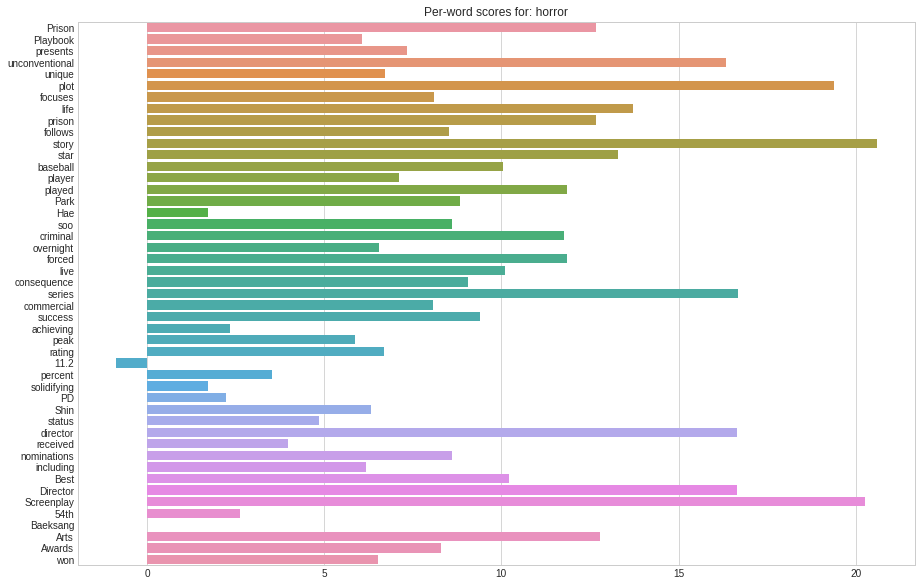

In [276]:
keyword = 'horror'
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title(f'Per-word scores for: {keyword}')
sns.barplot(x=raw_scores[keyword], y=word_list,
            label=word_list, ax=ax)
plt.show()

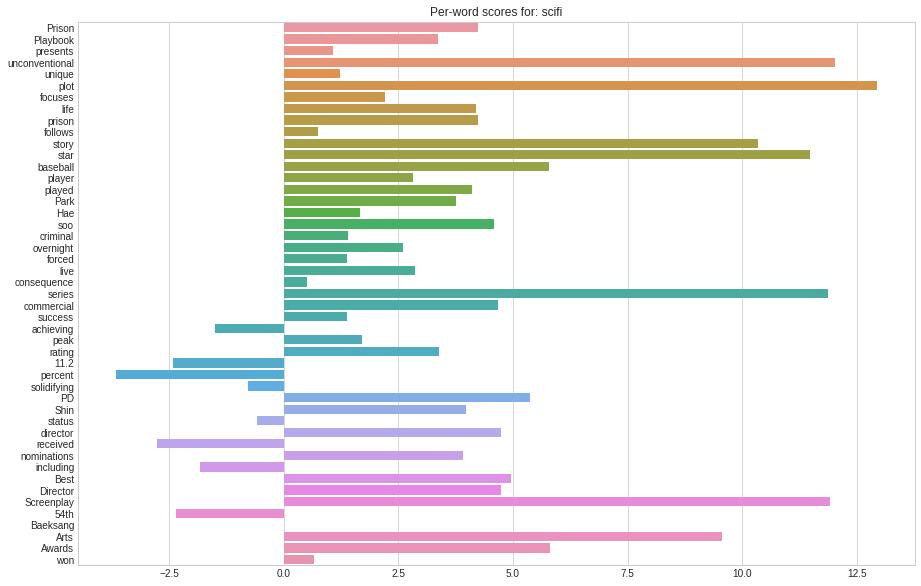

In [274]:
keyword = 'scifi'
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title(f'Per-word scores for: {keyword}')
sns.barplot(x=raw_scores[keyword], y=word_list,
            label=word_list, ax=ax)
plt.show()